# Modeling

In [1]:
# Imports
import pandas as pd
import numpy as np
#
import os
#!pip install pyyaml
import yaml
from utils.text import *
from tqdm.auto import tqdm  # for notebooks
#from tqdm import tqdm

# String manipulation
import re
import json

# NLP
import openai
from utils.gpt import get_absa

# Data visualisation
import plotly.graph_objects as go

with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

# Output folder 
in_dir = config['in_dir']
out_dir = config['out_dir']
os.environ["OPENAI_API_KEY"] = config["OPENAI_API_KEY"]
openai.api_key = os.getenv("OPENAI_API_KEY")
os.environ["FINE_TUNED_MODEL"] = config['FINE_TUNED_MODEL'] 



# Create the output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Dual task: Opinion Term Extraction (OTE), Aspect term polarity (ATP)

### Fine tuning

In [2]:
if config["debug"]:
  os.environ["OPENAI_API_KEY"] = ""
  openai.api_key = os.getenv("OPENAI_API_KEY")
  #openai.api_key = ""
  #'curie:ft-personal-2023-05-10-10-09-25' #OTE and sentiment
  !openai api fine_tunes.create -t data/train_data.jsonl -m curie
  # Checking the fine tuned model
  #fine_tunes_list = !openai api fine_tunes.list
  #fine_tunes_list

In [3]:
# Fine tuning the model
if config["train"]:
  # Getting the data
  trial_df = xml_to_dataframe('https://alt.qcri.org/semeval2016/task5/data/uploads/trial-data/english-trial/restaurants_trial_english_sl.xml')
  train_df = xml_to_dataframe(os.path.join(in_dir, 'raw\ABSA16_Restaurants_Train_SB1_v2.xml'), format='jsonl', output_file = 'train_data', in_dir = in_dir)
  test_df = xml_to_dataframe(os.path.join(in_dir, 'raw\EN_REST_SB1_TEST.xml.gold'), format='jsonl', output_file = 'test_data', in_dir = in_dir)

  !openai api fine_tunes.create -t data/train_data.jsonl -m davinci

In [4]:
# Checking available models
if config["train"]:
  # Information about the fine tuned model
  fine_tunes_list = !openai api fine_tunes.list
  # Convert to string
  fine_tunes_list = ''.join(fine_tunes_list)
  # Convert to dict
  fine_tunes_list = json.loads(fine_tunes_list)

  models, job_ids = list(), list()
  for model in fine_tunes_list['data']:
    models.append(model['fine_tuned_model'])
    job_ids.append(model['id'])
  
  # Saving model name, if it is null, wait some time before running 'fine_tunes.list'
  if config["rewrite"]:
    config['FINE_TUNED_MODEL'] = models[-1]
    with open('config.yml', 'w') as file:
        yaml.dump(config, file)
    os.environ["FINE_TUNED_MODEL"] = models[-1]
  else:
    # Adding temporarily the new model as the fine-tuned, resets when the session is over
    os.environ["FINE_TUNED_MODEL"] = models[-1]

  # Analyzing fine-tuned model 
  fine_tuning_results = !openai api fine_tunes.results -i {job_ids[-1]}
  # Delete fine-tuned model:
  ##openai.Model.delete(FINE_TUNED_MODEL)

else:
  trial_df = pd.read_parquet(os.path.join(in_dir, 'trial_data.parquet'))
  train_df = pd.read_parquet(os.path.join(in_dir, 'train_data.parquet'))
  test_df = pd.read_parquet(os.path.join(in_dir, 'test_data.parquet'))
  fine_tuning_results = pd.read_parquet(os.path.join(out_dir, 'fine_tuning_results.parquet'))

model = os.getenv("FINE_TUNED_MODEL")
model_name = model[:model.find(':')]+model[-15:]
model_name

'curie-05-10-10-09-25'

In [5]:
def graph_training_eval(fine_tuning_results = fine_tuning_results, title = 'Model evaluation', out_dir = out_dir, html = False, model_name = model_name):
  """
  Input: list of strins containing ['step', 'training_loss', 'training_token_accuracy']
  """
  # Data preparation
  if isinstance(fine_tuning_results, pd.DataFrame):
    df = fine_tuning_results
  else:   
    df = pd.DataFrame([string.split(',') for string in fine_tuning_results[1:]],
            columns = fine_tuning_results[0].split(',')).convert_dtypes()
    df.to_parquet(os.path.join(out_dir, 'fine_tuning_results.parquet'))

  # Visualisation
  fig = go.Figure()
  fig.add_trace(go.Scatter(x = df['step'], y = df['training_loss'].astype(float), mode='lines', name='Training Loss', line=dict(color='red')))
  fig.add_trace(go.Scatter(x = df['step'], y = df['training_token_accuracy'].astype(float), mode='lines', name='Training Accuracy', line=dict(color='blue')))

  fig.update_layout(title=title,
                    xaxis_title='Epoch',
                    yaxis_title='Metric',
                    legend=dict(x=0, y=-0.2, bgcolor='rgba(255, 255, 255, 0.5)', orientation='h'))
  if html:
    # Save fig as html
    fig.write_html(os.path.join(out_dir, "fine_tuning_results_"+model_name+".html"))
  else:
    # Save fig as png
    fig.write_image(os.path.join(out_dir, "fine_tuning_results_"+model_name+".png"))
  return fig

fig = graph_training_eval(title='Fine tuned model evaluation: '+model_name)
fig.show()

#### Testing the model

In [7]:
# Testing the model
if config["test"]:
  df = test_df
  tqdm.pandas()

  df.loc[:,["text_completion"]] = df["prompt"].progress_apply(lambda x: get_absa(x+"\n\n###\n\n", model = model, stop = [" END"]))
  # Formating
  df.loc[:,["absa"]] = df["text_completion"].progress_apply(lambda x: x["choices"][0]["text"].strip())
  # Save DataFrame
  df.to_parquet(os.path.join(out_dir, 'out_finetune_'+model_name+'.parquet'))
else:
  df = pd.read_parquet(os.path.join(out_dir, 'out_finetune_'+model_name+'.parquet'))

#### Model evaluation

Opinion Term Extraction

In [8]:
column = 'absa'
y_hat = break_column_into_rows(df.loc[:,["id", column]], column = column, pattern = "\n")
y_hat

,id,absa
0,en_BlueRibbonSushi_478218171,sushi; positive
0,en_BlueRibbonSushi_478218171,portions; neutral
0,en_BlueRibbonSushi_478218171,Green Tea creme brulee; positive
0,en_BlueRibbonSushi_478218171,NULL; positive
1,en_BlueRibbonSushi_478218345,place; positive
...,...,...
89,en_Ray'sBoathouse_477775918,chard; positive
89,en_Ray'sBoathouse_477775918,artichoke hearts; neutral
89,en_Ray'sBoathouse_477775918,fennel; neutral
89,en_Ray'sBoathouse_477775918,pecorino toscano; neutral


In [9]:
y_df = from_ai_to_df(df.loc[:,["id", "completion"]], column = "completion")
y_df = y_df.rename(columns={'Entity':'Sentiment'})

def clean_y_hat(df, column = 'absa'):
  """
  Formatting for the predictions
  """
  y_hat = break_column_into_rows(df.loc[:,["id", column]], column = column, pattern = "\n")
  y_hat = y_hat.drop_duplicates(ignore_index=True)
  # If the length is less than 6, there is no sentiment polarity detected. min = 'None'
  y_hat = y_hat[y_hat['absa'].str.len() >= 4]
  y_hat = split_column(y_hat, column_pattern =  ";", column = column)
  y_hat = y_hat.rename(columns={0:'OTE', 1:'Sentiment'})
  y_hat = y_hat.loc[:,["id", "OTE", "Sentiment"]]
  y_hat = y_hat.applymap(lambda x: x.replace('_', ' ').title().strip() if isinstance(x, str) else x)
  y_hat = y_hat[y_hat['Sentiment'].isin(['Positive', 'Negative', 'Neutral', 'None'])]
  y_hat['OTE'] = y_hat['OTE'].str.replace('"', '')
  return y_hat

y_hat = clean_y_hat(df)

result_df = y_df.merge(y_hat, left_on=['id','OTE'], right_on=['id','OTE'], suffixes=('_true', '_pred'), how='outer')
result_df.to_parquet(os.path.join(out_dir, 'result_df_'+model_name+'.parquet'))
result_df

,id,OTE,Sentiment_true,Sentiment_pred
0,En Blueribbonsushi 478218171,Null,Positive,Positive
1,En Blueribbonsushi 478218171,Sushi,Positive,Positive
2,En Blueribbonsushi 478218171,Portions,Neutral,Neutral
3,En Blueribbonsushi 478218171,Green Tea Creme Brulee,Positive,Positive
4,En Blueribbonsushi 478218345,Null,Positive,NaN
...,...,...,...,...
766,En Ray'Sboathouse 477775918,Chard,NaN,Positive
767,En Ray'Sboathouse 477775918,Artichoke Hearts,NaN,Neutral
768,En Ray'Sboathouse 477775918,Fennel,NaN,Neutral
769,En Ray'Sboathouse 477775918,Pecorino Toscano,NaN,Neutral


In [10]:
y_true = np.where(result_df['Sentiment_true'].isna(), "###", result_df['OTE'])
y_pred = np.where(result_df['Sentiment_pred'].isna(), "###", result_df['OTE'])

cm = report(y_true, y_pred, out_dir = out_dir, model_name = 'ote_'+model_name, display_report = False)

,precision,recall,f1-score,support
###,0.000000,0.000000,0.000000,74.000000
9 Oz Steak,1.000000,0.000000,0.000000,1.000000
Ambiance,1.000000,1.000000,1.000000,4.000000
Ambience,1.000000,1.000000,1.000000,3.000000
Appetizer,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
Yogurt,1.000000,0.000000,0.000000,1.000000
Young Woman,1.000000,0.000000,0.000000,1.000000
accuracy,0.654994,0.654994,0.654994,0.654994
macro avg,0.832181,0.636086,0.497178,771.000000


Aspect Term Polarity

,precision,recall,f1-score,support
Negative,0.597015,0.583942,0.590406,137.000000
Neutral,0.305556,0.234043,0.265060,47.000000
Positive,0.843521,0.672515,0.748373,513.000000
nan,0.000000,0.000000,0.000000,74.000000
accuracy,0.565499,0.565499,0.565499,0.565499
macro avg,0.436523,0.372625,0.400960,771.000000
weighted avg,0.685964,0.565499,0.619013,771.000000


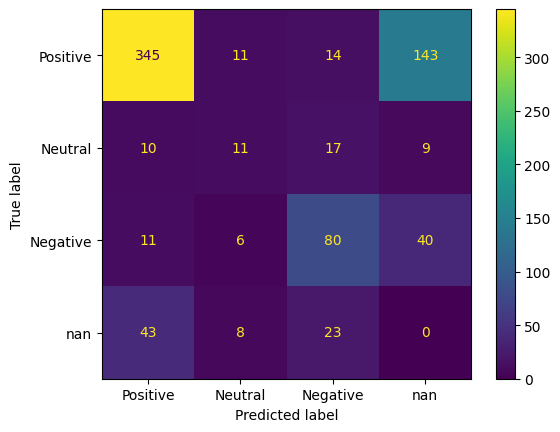

In [11]:
result_df.fillna(0)
y_true = result_df['Sentiment_true'].astype(str)
y_pred = result_df['Sentiment_pred'].astype(str)

report(y_true, y_pred, model_name = 'absa_'+model_name, display_labels = y_true.unique())

In [12]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process 

# Function to perform fuzzy matching and merging based on the 'id' column
def fuzzy_merge(df1, df2, on = ['id','OTE'], threshold=65):
    """
    Perform a full outer merge of df1 and df2 considering fuzzy matching on the columns 'on'
    """
    
    merged_df = pd.merge(df1, df2, on=on, how='outer', suffixes=('_true', '_pred'))

    for i, row in merged_df.iterrows():
        if pd.isna(row['Sentiment_pred']):
            name_match = process.extractOne(row[on[1]], df2[df2[on[0]] == row[on[0]]][on[1]], scorer=fuzz.ratio, score_cutoff=threshold)
            if name_match:
                matched_row = df2[df2[on[1]] == name_match[0]].iloc[0]
                merged_df.at[i, 'Sentiment_pred'] = matched_row['Sentiment']
                merged_df.at[i, 'Fuzzy match'] = str(name_match[0])+': '+str(name_match[1])
                # Remove the matched row
                merged_df = merged_df.drop(merged_df[(merged_df[on[0]] == row[on[0]]) & (merged_df[on[1]] == name_match[0])].index)

    return merged_df

def print_merged_ote(merged_df):
  """
  """
  out = merged_df['Sentiment_true'].isna().sum()
  not_found = merged_df['Sentiment_pred'].isna().sum()
  total = len(merged_df)
  found = total - out - not_found
  print(f"""Targets found out of scope: {out} ({round(out/total*100,2)}%) \n
  Targets that were not found: {not_found} ({round(not_found/total*100,2)}%) \n
  Targets found: {found} ({round(found/total*100,2)}%) \n
  Fuzzy matched targets: {merged_df['Fuzzy match'].count()} ({round(merged_df['Fuzzy match'].count()/total*100,2)}%) \n
  Total targets: {total}
  """)
  return

merged_df = fuzzy_merge(y_df, y_hat)
print_merged_ote(merged_df)

Targets found out of scope: 65 (8.63%) 

  Targets that were not found: 174 (23.11%) 

  Targets found: 514 (68.26%) 

  Fuzzy matched targets: 18 (2.39%) 

  Total targets: 753
  


,precision,recall,f1-score,support
Negative,0.701754,0.816327,0.754717,98.000000
Neutral,0.392857,0.289474,0.333333,38.000000
Positive,0.940860,0.925926,0.933333,378.000000
accuracy,0.857977,0.857977,0.857977,0.857977
macro avg,0.678491,0.677242,0.673795,514.000000
weighted avg,0.854758,0.857977,0.854920,514.000000


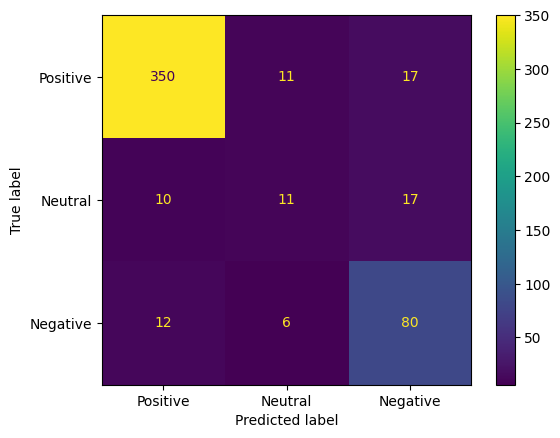

In [13]:
merged_df = merged_df.dropna(subset=['Sentiment_true', 'Sentiment_pred'])

report(merged_df['Sentiment_true'].astype(str), merged_df['Sentiment_pred'].astype(str), model_name = 'GPT_'+model_name, display_labels = merged_df['Sentiment_true'].astype(str).unique())

## Few-shot

In [31]:
from textwrap import dedent
instruction=dedent(
f"""Extract all opinion aspects and their sentiment polarity separated by ';' from the review:
"""
)
examples=dedent(
f"""
Review: Great sushi experience. Nice value. Unique apppetizers. Try sushimi cucumber roll.\n\n###\n\n
Answer: "sushi; positive
NULL; positive
apppetizers; positive
sushimi cucumber roll; positive END"

Review: Best Indian Restaurant in the City Decor needs to be upgraded but the food is amazing!\n\n###\n\n
Answer: "Indian Restaurant; positive
Decor; negative
food; positive END"

Review: LLOOVVE THIS PLACE. Food is excellent. Fish is so very fresh. Waitstaff are very friendly. Love YUKA.\n\n###\n\n
Answer: "PLACE; positive
Food; positive
Fish; positive
Waitstaff; positive
YUKA; positive END"

Review:
"""
)

In [34]:
model_name = "fewshot"

tqdm.pandas()

test_df = xml_to_dataframe(os.path.join(in_dir, 'raw\EN_REST_SB1_TEST.xml.gold'), format='jsonl', output_file = 'test_data', in_dir = in_dir, ACD = False)
df = test_df
df.loc[:,["text_completion"]] = df["prompt"].progress_apply(lambda x: get_absa(instruction + examples + x + "Answer: ", model = "text-davinci-003")) #code-davinci-002
df.loc[:,["absa"]] = df["text_completion"].progress_apply(lambda x: x["choices"][0]["text"].strip())
# Save DataFrame
df.to_parquet(os.path.join(out_dir, 'out_'+model_name+'.parquet'))

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [33]:
instruction + examples 

'Extract all opinion aspects and their sentiment polarity separated by \';\' from the review:\n\nReview: Great sushi experience. Nice value. Unique apppetizers. Try sushimi cucumber roll.\n\n###\n\n\nAnswer: "sushi; positive\nNULL; positive\napppetizers; positive\nsushimi cucumber roll; positive END"\n\nReview: Best Indian Restaurant in the City Decor needs to be upgraded but the food is amazing!\n\n###\n\n\nAnswer: "Indian Restaurant; positive\nDecor; negative\nfood; positive END"\n\nReview: LLOOVVE THIS PLACE. Food is excellent. Fish is so very fresh. Waitstaff are very friendly. Love YUKA.\n\n###\n\n\nAnswer: "PLACE; positive\nFood; positive\nFish; positive\nWaitstaff; positive\nYUKA; positive END"\n\nReview:\n'

In [15]:
# Testing the model
model_name = "fewshot"
if config["fewshot"]:
  tqdm.pandas()
  
  test_df = xml_to_dataframe(os.path.join(in_dir, 'raw\EN_REST_SB1_TEST.xml.gold'), format='jsonl', output_file = 'test_data', in_dir = in_dir, ACD = False)
  df = test_df
  df.loc[:,["text_completion"]] = df["prompt"].progress_apply(lambda x: get_absa(instruction + examples + x + "Answer: ", model = "text-davinci-003")) #code-davinci-002
  df.loc[:,["absa"]] = df["text_completion"].progress_apply(lambda x: x["choices"][0]["text"].strip())
  # Save DataFrame
  df.to_parquet(os.path.join(out_dir, 'out_'+model_name+'.parquet'))
else:
  df = pd.read_parquet(os.path.join(out_dir, 'out_'+model_name+'.parquet'))

### Model Evaluation

OTE

In [35]:
y_df = from_ai_to_df(df.loc[:,["id", "completion"]], column = "completion")
y_df = y_df.rename(columns={'Entity':'Sentiment'})
#  Formatting for the predictions
y_hat = clean_y_hat(df)

result_df = y_df.merge(y_hat, left_on=['id','OTE'], right_on=['id','OTE'], suffixes=('_true', '_pred'), how='outer')
result_df.to_parquet(os.path.join(out_dir, 'result_df_'+model_name+'.parquet'))

y_true = np.where(result_df['Sentiment_true'].isna(), "###", result_df['OTE'])
y_pred = np.where(result_df['Sentiment_pred'].isna(), "###", result_df['OTE'])

cm = report(y_true, y_pred, out_dir = out_dir, model_name = 'ote_'+model_name, display_report = False)

merged_df = fuzzy_merge(y_df, y_hat)
print_merged_ote(merged_df)

,precision,recall,f1-score,support
###,0.000000,0.000000,0.000000,226.000000
$6 With Tip,0.000000,1.000000,0.000000,0.000000
9 Oz Steak,1.000000,0.000000,0.000000,1.000000
Accomodating,0.000000,1.000000,0.000000,0.000000
Alaskan King Salmon,0.000000,1.000000,0.000000,0.000000
...,...,...,...,...
Young Children For Dinner,0.000000,1.000000,0.000000,0.000000
Young Woman,1.000000,0.000000,0.000000,1.000000
accuracy,0.427784,0.427784,0.427784,0.427784
macro avg,0.594667,0.743752,0.363211,907.000000


Targets found out of scope: 198 (22.89%) 

  Targets that were not found: 251 (29.02%) 

  Targets found: 416 (48.09%) 

  Fuzzy matched targets: 42 (4.86%) 

  Total targets: 865
  


ATP

,precision,recall,f1-score,support
Negative,0.861538,0.823529,0.842105,68.000000
Neutral,0.500000,0.117647,0.190476,17.000000
Positive,0.936599,0.981873,0.958702,331.000000
accuracy,0.920673,0.920673,0.920673,0.920673
macro avg,0.766046,0.641017,0.663761,416.000000
weighted avg,0.906488,0.920673,0.908249,416.000000


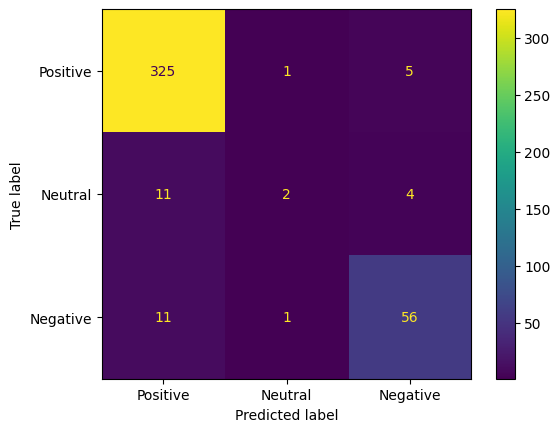

In [36]:
merged_df = merged_df.dropna(subset=['Sentiment_true', 'Sentiment_pred'])

report(merged_df['Sentiment_true'].astype(str), merged_df['Sentiment_pred'].astype(str), model_name = 'GPT_'+model_name, display_labels = merged_df['Sentiment_true'].astype(str).unique())

,precision,recall,f1-score,support
Negative,0.439394,0.436090,0.437736,133.000000
Neutral,0.181818,0.048780,0.076923,41.000000
Positive,0.647558,0.601578,0.623722,507.000000
nan,0.000000,0.000000,0.000000,226.000000
accuracy,0.402426,0.402426,0.402426,0.402426
macro avg,0.317193,0.271612,0.284595,907.000000
weighted avg,0.434626,0.402426,0.416317,907.000000


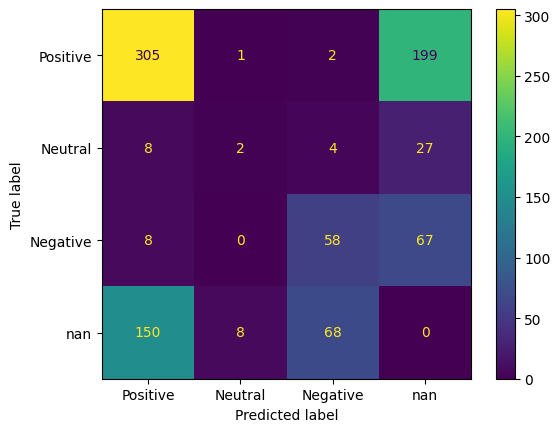

In [38]:
report(result_df['Sentiment_true'].astype(str), result_df['Sentiment_pred'].astype(str), model_name = 'GPT_'+model_name, display_labels = result_df['Sentiment_true'].astype(str).unique())

## Zero-shot

In [19]:
# Testing the model
model_name = "zeroshot"
if config["zeroshot"]:
  tqdm.pandas()
  
  df = test_df
  df.loc[:,["text_completion"]] = df["prompt"].progress_apply(lambda x: get_absa(instruction + x, model = "text-davinci-003")) #code-davinci-002
  df.loc[:,["absa"]] = df["text_completion"].progress_apply(lambda x: x["choices"][0]["text"].strip())
  # Save DataFrame
  df.to_parquet(os.path.join(out_dir, 'out_'+model_name+'.parquet'))
else:
  df = pd.read_parquet(os.path.join(out_dir, 'out_'+model_name+'.parquet'))

### Model Evaluation

OTE

In [20]:
model_name = "zeroshot"
y_df = from_ai_to_df(df.loc[:,["id", "completion"]], column = "completion")
y_df = y_df.rename(columns={'Entity':'Sentiment'})
#  Formatting for the predictions
y_hat = clean_y_hat(df)

result_df = y_df.merge(y_hat, left_on=['id','OTE'], right_on=['id','OTE'], suffixes=('_true', '_pred'), how='outer')
result_df.to_parquet(os.path.join(out_dir, 'result_df_'+model_name+'.parquet'))

y_true = np.where(result_df['Sentiment_true'].isna(), "###", result_df['OTE'])
y_pred = np.where(result_df['Sentiment_pred'].isna(), "###", result_df['OTE'])

cm = report(y_true, y_pred, out_dir = out_dir, model_name = 'ote_'+model_name, display_report = False)

merged_df = fuzzy_merge(y_df, y_hat)
print_merged_ote(merged_df)

,precision,recall,f1-score,support
###,0.000000,0.000000,0.000000,27.00000
9 Oz Steak,1.000000,0.000000,0.000000,1.00000
Ambiance,1.000000,0.500000,0.666667,4.00000
Ambience,1.000000,0.000000,0.000000,3.00000
Appetizer,1.000000,0.000000,0.000000,1.00000
...,...,...,...,...
Yogurt,1.000000,0.000000,0.000000,1.00000
Young Woman,1.000000,0.000000,0.000000,1.00000
accuracy,0.045390,0.045390,0.045390,0.04539
macro avg,0.928617,0.095323,0.032061,705.00000


Targets found out of scope: 24 (3.44%) 

  Targets that were not found: 636 (91.25%) 

  Targets found: 37 (5.31%) 

  Fuzzy matched targets: 10 (1.43%) 

  Total targets: 697
  


ATP

,precision,recall,f1-score,support
Negative,0.750000,0.750000,0.750000,4.000000
Neutral,1.000000,0.000000,0.000000,2.000000
Positive,0.909091,0.967742,0.937500,31.000000
accuracy,0.891892,0.891892,0.891892,0.891892
macro avg,0.886364,0.572581,0.562500,37.000000
weighted avg,0.896806,0.891892,0.866554,37.000000


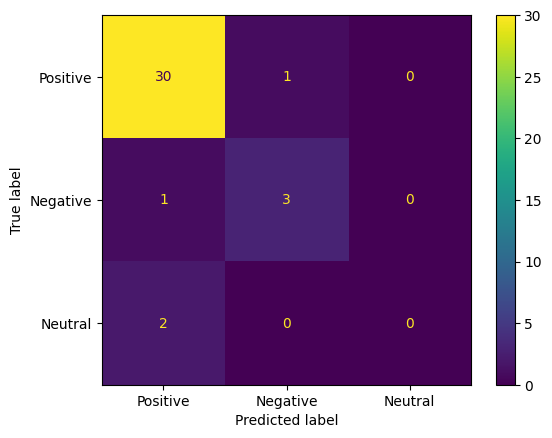

In [21]:
merged_df = merged_df.dropna(subset=['Sentiment_true', 'Sentiment_pred'])

report(merged_df['Sentiment_true'].astype(str), merged_df['Sentiment_pred'].astype(str), model_name = 'GPT_'+model_name, display_labels = merged_df['Sentiment_true'].astype(str).unique())

,precision,recall,f1-score,support
Negative,0.222222,0.015038,0.028169,133.000000
Neutral,1.000000,0.000000,0.000000,41.000000
Positive,0.560000,0.055556,0.101083,504.000000
nan,0.000000,0.000000,0.000000,27.000000
accuracy,0.042553,0.042553,0.042553,0.042553
macro avg,0.445556,0.017648,0.032313,705.000000
weighted avg,0.500419,0.042553,0.077578,705.000000


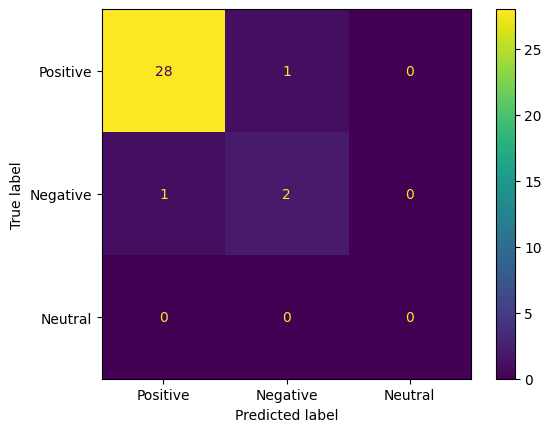

In [22]:
report(result_df['Sentiment_true'].astype(str), result_df['Sentiment_pred'].astype(str), model_name = 'GPT_'+model_name, display_labels = merged_df['Sentiment_true'].astype(str).unique())

## Multi-task: Opinion Term Extraction (OTE), Aspect term polarity (ATP), Aspect category detection (ACD)

In [23]:
from textwrap import dedent
instruction=dedent(
f"""Extract all opinion aspects, their category and the sentiment polarity separated by ';' from the review:
"""
)
examples=dedent(
f"""
Review: Great sushi experience. Nice value. Unique apppetizers. Try sushimi cucumber roll.

Answer: "sushi; FOOD QUALITY; positive
NULL; RESTAURANT PRICES; positive
apppetizers; FOOD QUALITY; positive
sushimi cucumber roll; FOOD QUALITY; positive"

Review: Best Indian Restaurant in the City Decor needs to be upgraded but the food is amazing!
Answer: "Indian Restaurant; RESTAURANT GENERAL; positive
Decor; AMBIENCE GENERAL; negative
food; FOOD QUALITY; positive"

Review: LLOOVVE THIS PLACE. Food is excellent. Fish is so very fresh. Waitstaff are very friendly. Love YUKA.
Answer: "PLACE; RESTAURANT GENERAL; positive
Food; FOOD QUALITY; positive
Fish; FOOD QUALITY; positive
Waitstaff; SERVICE GENERAL; positive
YUKA; RESTAURANT GENERAL; positive"

Review:
"""
)

In [24]:
if config["retrain"]:
  TRAIN_FILE = os.path.join(in_dir, 'data\train_data.jsonl')
  VALIDATION_FILE = os.path.join(in_dir, 'data\test_data.jsonl')

  !openai api fine_tunes.create -t {TRAIN_FILE} \
  -v {VALIDATION_FILE} \
  -m {os.environ["FINE_TUNED_MODEL"]} 

  # Information about the fine tuned model
  fine_tunes_list = !openai api fine_tunes.list
  # Convert to string
  fine_tunes_list = ''.join(fine_tunes_list)
  # Convert to dict
  fine_tunes_list = json.loads(fine_tunes_list)

  models, job_ids = list(), list()
  for model in fine_tunes_list['data']:
    models.append(model['fine_tuned_model'])
    job_ids.append(model['id'])

  os.environ["FINE_TUNED_MODEL"] = models[-1]

  # Analyzing fine-tuned model 
  fine_tuning_results = !openai api fine_tunes.results -i {job_ids[-1]}
  # Delete fine-tuned model:
  ##openai.Model.delete(FINE_TUNED_MODEL)